## Import all necessary packages. 

In [1]:
from shapely.geometry import Point
import pandas as pd
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

## Import all files: csv's and geojsons

In [2]:
tornado_calls = pd.read_csv('../data/911_Phone_Calls_Tornado_030320.csv')
derecho_calls = pd.read_csv('../data/911_Phone Calls_Derecho_050320_050420.csv')
tornado_incidents = pd.read_csv('../data/Data_Tornado.csv', skiprows = 3)
derecho_incidents = pd.read_csv('../data/Data_Derecho.csv', skiprows = 3)

In [3]:
damage_points = gpd.read_file('../data/damage_points.geojson')
path_polygons = gpd.read_file('../data/path_polygons.geojson')
tornado_paths = gpd.read_file('../data/tornado_paths.geojson')

## Change and clean the data: rename columns, convert to datetime for time column, add geometry columns.

In [4]:
tornado_calls = tornado_calls.rename(columns = {'Seizure DateTime': 'time', 'CallTypeId': 'call', 'ALI Latitude': 'lat', 'ALI Longitude': 'lng', 'Cell Tower Address': 'tower_addy' })
tornado_calls.head(1)

,time,call,lat,lng,tower_addy
0,3/3/2020 0:34,911 Calls,36.072708,-86.665779,620 Richards RD - N Sector


In [5]:
derecho_calls = derecho_calls.rename(columns = {'Seizure DateTime': 'time', 'CallTypeId': 'call', 'ALI Latitude': 'lat', 'ALI Longitude': 'lng', 'Cell Tower Address': 'tower_addy' })
derecho_calls

,time,call,lat,lng,tower_addy
0,5/3/2020 16:30,911 Calls,36.247802,-86.716847,WIRELESS CALLER
1,5/3/2020 16:30,911 Calls,36.143108,-86.800621,1161 21ST AV S - SE
2,5/3/2020 16:30,911 Calls,36.100516,-87.056329,8013 C MCCRORY LN - N
3,5/3/2020 16:30,911 Calls,36.130021,-86.927819,5758 RIVER RD - SW
4,5/3/2020 16:31,911 Calls,36.142380,-86.881882,3744B ANNEX AVE - SE
...,...,...,...,...,...
1544,5/4/2020 0:18,911 Calls,36.131694,-86.770535,1823-C 12TH AV - SECTOR SE S
1545,5/4/2020 0:22,911 Calls,36.042237,-86.743455,5244-C EDMONSON PIKE - SECTOR SE
1546,5/4/2020 0:25,911 Calls,36.077664,-86.655607,2747-B MURFREESBORO PKE - SECTOR NW
1547,5/4/2020 0:29,911 Calls,36.024706,-86.743562,302 SUMMIT VIEW DR - E


In [6]:
tornado_incidents = tornado_incidents.rename(columns = {'IncidentDate': 'time', 'Location':'location', 'Latitude1':'lat', 'Longitude1':'lng', 'IncidentTypeDescription1':'indcident_desc'})
tornado_incidents.head(1)

,time,location,lat,lng,indcident_desc
0,3/3/2020 12:36:34 AM,6205 COCKRILL BEND CIR,36.182002,-86.894052,GENERAL ALARM COMMERCIAL INDUSTRIAL BUILD


In [7]:
derecho_incidents = derecho_incidents.rename(columns = {'IncidentDate': 'time', 'Location':'location', 'Latitude1':'lat', 'Longitude1':'lng', 'IncidentTypeDescription1':'indcident_desc'})
derecho_incidents.head(1)

,time,location,lat,lng,indcident_desc
0,5/3/2020 4:31:07 PM,901 KENWICK CT W,36.046877,-86.962526,ELECTRICAL HAZARD


In [8]:
tornado_calls.time = pd.to_datetime(tornado_calls.time)
derecho_calls.time = pd.to_datetime(derecho_calls.time)
tornado_incidents.time = pd.to_datetime(tornado_incidents.time)
derecho_incidents.time = pd.to_datetime(derecho_incidents.time)

In [9]:
tornado_calls['geometry'] = tornado_calls.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
derecho_calls['geometry'] = derecho_calls.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
tornado_incidents['geometry'] = tornado_incidents.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
derecho_incidents['geometry'] = derecho_incidents.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

## Check all DF dtypes.

In [10]:
tornado_paths['stormdate'] = tornado_paths['stormdate'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
tornado_paths['starttime'] = tornado_paths['starttime'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
tornado_paths['endtime'] = tornado_paths['endtime'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))

In [11]:
tornado_paths.head()

,objectid,event_id,stormdate,starttime,endtime,startlat,startlon,endlat,endlon,length,...,propdamage,edit_user,edit_time,created_user,created_date,last_edited_user,last_edited_date,comments,Shape__Length,geometry
0,879879,Nashville,2020-03-03 00:32:00,2020-03-03 00:32:00,2020-03-03 01:35:00,36.1725,-86.9478,36.1532,-85.8860,60.1317,...,-99,None,None,DATians,1583461561000,dat_editor,1618703241000,"An historic, long-track, strong EF-3 tornado b...",1.071075,"LINESTRING (-86.94783 36.17249, -86.94461 36.1..."
1,879077,Hwy 69 Ballpark Tornado,2020-03-03 06:04:00,2020-03-03 06:04:00,2020-03-03 06:12:00,32.6846,-87.6226,32.6863,-87.5492,4.3400,...,-99,None,None,DATians,1583353305000,DATians,1583358165000,None,0.074159,"LINESTRING (-87.62263 32.68464, -87.62182 32.6..."
2,879081,Lawley Tornado,2020-03-03 06:28:00,2020-03-03 06:28:00,2020-03-03 06:38:00,32.8648,-87.0496,32.8646,-86.9432,6.2100,...,-99,None,None,DATians,1583357522000,DATians,1583359203000,Path,0.106695,"LINESTRING (-87.04956 32.86476, -87.04019 32.8..."
3,879877,Cookeville,2020-03-03 01:48:00,2020-03-03 01:48:00,2020-03-03 01:56:00,36.1715,-85.6628,36.1709,-85.5135,8.3900,...,100000,None,None,DATians,1583461208000,DATians,1590771008000,"An historic, violent EF-4 tornado began in wes...",0.149870,"LINESTRING (-85.66285 36.17151, -85.61103 36.1..."
4,879878,Goffton,2020-03-03 02:05:00,2020-03-03 02:05:00,2020-03-03 02:06:00,36.1075,-85.4461,36.1068,-85.4420,0.2300,...,-99,None,None,DATians,1583461360000,DATians,1590604073000,A very brief and weak EF-0 tornado touched dow...,0.004130,"LINESTRING (-85.44610 36.10746, -85.44203 36.1..."


In [12]:
damage_points.dtypes

objectid                 int64
stormdate                int64
surveydate               int64
event_id                object
damage                   int64
damage_txt              object
dod_txt                 object
efscale                 object
damage_dir              object
windspeed               object
injuries                 int64
deaths                   int64
lat                    float64
lon                    float64
office                  object
image                   object
gps_horiz_accuracy      object
device_id               object
qc                      object
dod                      int64
surveytype              object
globalid                object
edit_user               object
edit_time               object
comments                object
path_guid               object
geometry              geometry
dtype: object

In [13]:
damage_points

,objectid,stormdate,surveydate,event_id,damage,damage_txt,dod_txt,efscale,damage_dir,windspeed,...,device_id,qc,dod,surveytype,globalid,edit_user,edit_time,comments,path_guid,geometry
0,2047717,1583218620000,1583335680000,Mount Juliet,2,One- or Two-Family Residences (FR12),All walls collapsed,EF3,N/A,155,...,None,Y,9,None,{FE82BBAC-ABF8-4562-81F6-A527829FBFFE},None,None,none,None,POINT (-86.51628 36.18344)
1,2047909,1583221860000,1583437860000,Cookeville,27,Trees: Hardwood (TH),Trees uprooted,EF0,N/A,80,...,None,Y,3,None,{2417B433-0C00-4D6C-A059-45E0CFDA2AF6},None,None,none,None,POINT (-85.60552 36.17308)
2,2075630,1583221980000,1586759820000,Cookeville,2,One- or Two-Family Residences (FR12),"Loss of roof covering material (<20%), gutters...",EF0,N/A,80,...,None,Y,2,None,{10AC67A3-D75D-4E6E-82B8-DD307E183FC0},None,None,None,None,POINT (-85.57574 36.17740)
3,2060941,1583217780000,1585242540000,,1,Small Barns or Farm Outbuildings (SBO),Total destruction of building,EF1,N/A,95,...,None,Y,8,None,{A0744CB4-5993-4056-A13C-CF75182F5147},None,None,None,None,POINT (-86.76228 36.17340)
4,2060984,1583217780000,1585256400000,,7,Masonry Apartment or Motel Building (MAM),Loss of roof covering (<20%),EF0,N/A,80,...,None,Y,2,None,{DA83D428-084A-4ACA-A39E-DEE84AA28463},None,None,None,None,POINT (-86.75692 36.17568)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3962,2114432,1583219640000,1588470780000,,3,Manufactured Home - Single Wide (MHSW),Loss of shingles or partial uplift of one-piec...,EF0,N/A,75,...,None,Y,2,None,{44F412AC-5781-48C8-96BA-C55B7988DD17},None,None,None,None,POINT (-86.22961 36.19636)
3963,2114433,1583219700000,1588472700000,,2,One- or Two-Family Residences (FR12),"Loss of roof covering material (<20%), gutters...",EF0,N/A,85,...,None,Y,2,None,{874F6609-57F6-46B6-ACE9-4B699685233D},None,None,None,None,POINT (-86.20841 36.19219)
3964,2114434,1583220360000,1588482840000,,1,Small Barns or Farm Outbuildings (SBO),Total destruction of building,EF1,N/A,95,...,None,Y,8,None,{F21CA6EF-0A9C-4653-9D2A-87ECC197B98F},None,None,None,None,POINT (-86.02540 36.17764)
3965,2320477,1583217120000,1618702140000,Nashville,29,Other (O),Other damage,EF0,N/A,70,...,None,Y,1,None,{5071191E-4409-4F75-BD83-BE52ED30723C},None,None,Boathouse and dock blown northward and heavily...,None,POINT (-86.94269 36.17417)


In [14]:
damage_points['stormdate'] = damage_points['stormdate'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
damage_points['surveydate'] = damage_points['surveydate'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))

In [15]:
damage_points.head()

,objectid,stormdate,surveydate,event_id,damage,damage_txt,dod_txt,efscale,damage_dir,windspeed,...,device_id,qc,dod,surveytype,globalid,edit_user,edit_time,comments,path_guid,geometry
0,2047717,2020-03-03 00:57:00,2020-03-04 09:28:00,Mount Juliet,2,One- or Two-Family Residences (FR12),All walls collapsed,EF3,N/A,155,...,None,Y,9,None,{FE82BBAC-ABF8-4562-81F6-A527829FBFFE},None,None,none,None,POINT (-86.51628 36.18344)
1,2047909,2020-03-03 01:51:00,2020-03-05 13:51:00,Cookeville,27,Trees: Hardwood (TH),Trees uprooted,EF0,N/A,80,...,None,Y,3,None,{2417B433-0C00-4D6C-A059-45E0CFDA2AF6},None,None,none,None,POINT (-85.60552 36.17308)
2,2075630,2020-03-03 01:53:00,2020-04-13 01:37:00,Cookeville,2,One- or Two-Family Residences (FR12),"Loss of roof covering material (<20%), gutters...",EF0,N/A,80,...,None,Y,2,None,{10AC67A3-D75D-4E6E-82B8-DD307E183FC0},None,None,None,None,POINT (-85.57574 36.17740)
3,2060941,2020-03-03 00:43:00,2020-03-26 12:09:00,,1,Small Barns or Farm Outbuildings (SBO),Total destruction of building,EF1,N/A,95,...,None,Y,8,None,{A0744CB4-5993-4056-A13C-CF75182F5147},None,None,None,None,POINT (-86.76228 36.17340)
4,2060984,2020-03-03 00:43:00,2020-03-26 16:00:00,,7,Masonry Apartment or Motel Building (MAM),Loss of roof covering (<20%),EF0,N/A,80,...,None,Y,2,None,{DA83D428-084A-4ACA-A39E-DEE84AA28463},None,None,None,None,POINT (-86.75692 36.17568)


# 1. Develop a timeline of each storm based on the call locations and volume. This can include the following:
- Beginning and end of the event, based on call times
- Times of stronger storm impacts, based on call volumes

#### Transform tornado calls, derecho calls, derecho incidents, and tornado, incidents to GDF and plot their location on map. 

In [18]:
print(tornado_paths.crs)

epsg:4326


In [90]:
tornado_calls_gpd = gpd.GeoDataFrame(tornado_calls,
                                     crs = tornado_paths.crs,
                                     geometry = tornado_calls['geometry'])
tornado_calls_gpd.head(2)

,time,call,lat,lng,tower_addy,geometry
0,2020-03-03 00:34:00,911 Calls,36.072708,-86.665779,620 Richards RD - N Sector,POINT (-86.66578 36.07271)
1,2020-03-03 00:36:00,911 Calls,36.159634,-86.841904,4507D KENTUCKY AV - SE,POINT (-86.84190 36.15963)


In [22]:
derecho_calls_gpd = gpd.GeoDataFrame(derecho_calls,
                                     crs = tornado_paths.crs,
                                     geometry = derecho_calls['geometry'])

tornado_incidents = gpd.GeoDataFrame(tornado_incidents,
                                     crs = tornado_paths.crs,
                                     geometry = tornado_incidents['geometry'])

derecho_incidents = gpd.GeoDataFrame(derecho_incidents,
                                     crs = tornado_paths.crs,
                                     geometry = derecho_incidents['geometry'])

#### Tornado calls plot shows a large call volume in the west of Davidson County. Overlay on folium map. Add tornado_paths GDF to compare what tornado that might have been.

<AxesSubplot:>

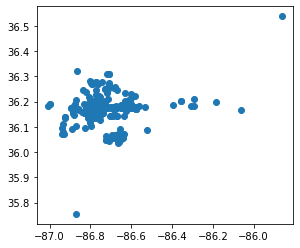

In [21]:
tornado_calls_gpd.plot()

In [28]:
tornado_paths.geometry.centroid

C:\Users\olari\AppData\Local\Temp/ipykernel_29488/591618702.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tornado_paths.geometry.centroid


0    POINT (-86.41602 36.18173)
1    POINT (-87.58605 32.68822)
2    POINT (-86.99640 32.86431)
3    POINT (-85.58815 36.17430)
4    POINT (-85.44407 36.10713)
5    POINT (-84.95104 36.13381)
6    POINT (-85.77695 36.16682)
dtype: geometry

In [35]:
center = tornado_paths.geometry.centroid[0]

C:\Users\olari\AppData\Local\Temp/ipykernel_29488/468265422.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = tornado_paths.geometry.centroid[0]


In [36]:
area_center = [center.y, center.x]
print(area_center)

[36.181727228463764, -86.41601809638975]


In [57]:
folium.GeoJson(path_polygons).add_to(calls_map)


In [40]:
folium.Map?

In [50]:
nash_tornado = tornado_paths.loc[tornado_paths['event_id'] == 'Nashville']

In [53]:
nash_tornado = nash_tornado[['geometry']]
nash_tornado

,geometry
0,"LINESTRING (-86.94783 36.17249, -86.94461 36.1..."


In [94]:
tornado_calls_gpd = tornado_calls_gpd.dropna()
tornado_calls_gpd

,time,call,lat,lng,tower_addy,geometry
0,2020-03-03 00:34:00,911 Calls,36.072708,-86.665779,620 Richards RD - N Sector,POINT (-86.66578 36.07271)
1,2020-03-03 00:36:00,911 Calls,36.159634,-86.841904,4507D KENTUCKY AV - SE,POINT (-86.84190 36.15963)
2,2020-03-03 00:36:00,911 Calls,36.264153,-86.708862,329 THELMA ST - S Sector,POINT (-86.70886 36.26415)
4,2020-03-03 00:36:00,911 Calls,36.233467,-86.721077,5007B RUSKIN AVE - N,POINT (-86.72108 36.23347)
5,2020-03-03 00:37:00,911 Calls,36.149032,-86.795747,WIRELESS CALLER,POINT (-86.79575 36.14903)
...,...,...,...,...,...,...
470,2020-03-03 04:54:00,911 Calls,36.142552,-86.635330,WIRELESS CALLER,POINT (-86.63533 36.14255)
471,2020-03-03 04:54:00,911 Calls,36.189415,-86.813557,WIRELESS CALLER,POINT (-86.81356 36.18941)
472,2020-03-03 04:55:00,911 Calls,36.223534,-86.757874,WIRELESS CALLER,POINT (-86.75787 36.22353)
473,2020-03-03 04:56:00,911 Calls,36.168398,-86.783774,600 DR MARTIN L KING JR BLVD - NE,POINT (-86.78377 36.16840)


In [97]:
for row_index, row_values in tornado_calls_gpd.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['time'])
    icon=folium.Icon(color="red",icon='wind', prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(calls_map)
calls_map

In [93]:
calls_grouped = tornado_calls_gpd.groupby([pd.Grouper(key = 'time', freq='30min')]).count().reset_index()


,time,call,lat,lng,tower_addy,geometry
0,2020-03-03 00:30:00,93,93,93,93,93
1,2020-03-03 01:00:00,95,95,95,95,95
2,2020-03-03 01:30:00,92,92,92,92,92
3,2020-03-03 02:00:00,57,57,57,57,57
4,2020-03-03 02:30:00,23,23,23,23,23
5,2020-03-03 03:00:00,22,22,22,22,22
6,2020-03-03 03:30:00,23,23,23,23,23
7,2020-03-03 04:00:00,19,19,19,19,19
8,2020-03-03 04:30:00,26,26,26,26,26


In [99]:
calls_grouped1 = calls_grouped.iloc[0]

In [100]:
calls_grouped1

time          2020-03-03 00:30:00
call                           93
lat                            93
lng                            93
tower_addy                     93
geometry                       93
Name: 0, dtype: object

In [101]:
derecho_calls_grouped = derecho_calls.groupby([pd.Grouper(key = 'time', freq='30min')]).count().reset_index()
derecho_calls_grouped

,time,call,lat,lng,tower_addy,geometry
0,2020-05-03 16:30:00,142,138,138,138,142
1,2020-05-03 17:00:00,130,110,110,121,130
2,2020-05-03 17:30:00,152,146,146,148,152
3,2020-05-03 18:00:00,155,148,148,151,155
4,2020-05-03 18:30:00,196,188,188,195,196
5,2020-05-03 19:00:00,153,151,151,153,153
6,2020-05-03 19:30:00,114,108,108,112,114
7,2020-05-03 20:00:00,112,111,111,112,112
8,2020-05-03 20:30:00,77,76,76,77,77
9,2020-05-03 21:00:00,66,63,63,66,66


In [89]:
for index, rows in calls_grouped.iterrows():
        icon=folium.Icon(color="blue",icon='wind', prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(calls_map)
calls_map

Object `for` not found.


In [ ]:
# derecho_grouper_1h = derecho_calls.groupby(by=[pd.Grouper(key = 'Call_Time', freq='1h'), "Emergency_Calls"]).count().reset_index()
# derecho_grouper_1h
# derecho_calls['Call_Time'] = pd.to_datetime(derecho_calls['Call_Time'])
# derecho_calls['elapsed'] = derecho_calls['Call_Time'] - derecho_calls['Call_Time'].min()
